In [ ]:
import numpy as np
from numpy.linalg import norm

In [ ]:
def objective(v, C):
    return v.T @ C @ v

In [5]:
def simulated_annealing(C, max_iter=1000, T0=100, alpha=0.99):
    d = C.shape[0]
    v_current = np.random.randn(d)
    v_current /= norm(v_current)

    T = T0
    best_v = v_current.copy()
    best_f = objective(best_v, C)

    for _ in range(max_iter):
        # تولید همسایه
        v_new = v_current + 0.1 * np.random.randn(d)
        v_new /= norm(v_new)
         # محاسبه تابع هدف
        f_current = objective(v_current, C)
        f_new = objective(v_new, C)

        delta = f_new - f_current

        # قبول یا رد
        if delta > 0 or np.random.rand() < np.exp(delta / T):
            v_current = v_new
            if f_new > best_f:
                best_v = v_new
                best_f = f_new
        T *= alpha

    return best_v, best_f

In [7]:
# داده‌ها
X = np.array([[2, 3], [4, 5], [6, 7]])
X_centered = X - np.mean(X, axis=0)
C = np.cov(X_centered, rowvar=False)
C

array([[4., 4.],
       [4., 4.]])

In [8]:
# اجرای SA
best_v, best_f = simulated_annealing(C)

print("Best direction found:", best_v)
print("Variance captured:", best_f)

Best direction found: [-0.70730307 -0.70691044]
Variance captured: 7.999999383345966


کد Python – PCA با SA برای k>1

In [13]:
import numpy as np
from numpy.linalg import qr, norm, trace

def objective(V, C):
    return trace(V.T @ C @ V)

def random_perturbation(V, scale=0.1):
    d, k = V.shape
    perturb = V + scale * np.random.randn(d, k)
    Q, _ = qr(perturb)
    return Q

def simulated_annealing_multi(C, k, max_iter=1000, T0=100, alpha=0.99):
    d = C.shape[0]
    # مقداردهی اولیه با QR
    W = np.random.randn(d, k)
    V_current, _ = qr(W)
    best_V = V_current.copy()
    best_f = objective(best_V, C)

    T = T0
    for _ in range(max_iter):
        V_new = random_perturbation(V_current)
        f_current = objective(V_current, C)
        f_new = objective(V_new, C)
        delta = f_new - f_current

        if delta > 0 or np.random.rand() < np.exp(delta / T):
            V_current = V_new
            if f_new > best_f:
                best_V = V_new
                best_f = f_new

        T *= alpha

    return best_V, best_f

# داده‌ها
X = np.array([[2, 3], [4, 5], [6, 7]])
X_centered = X - np.mean(X, axis=0)
C = np.cov(X_centered, rowvar=False)

# اجرای SA برای k=2
best_V, best_f = simulated_annealing_multi(C, k=2)

print("Best matrix V found:\n", best_V)
print("Total variance captured:", best_f)

Best matrix V found:
 [[-0.5186532  -0.85498471]
 [-0.85498471  0.5186532 ]]
Total variance captured: 8.000000000000007


In [14]:
import numpy as np
from sklearn.decomposition import PCA
from PIL import Image
import matplotlib.pyplot as plt

In [15]:
def load_image(path):
    img = Image.open(path)
    if img.mode != 'RGB':
        img = img.convert('RGB')
    return np.array(img) / 255.0  # نرمال‌سازی به [0,1]

def show_images(original, compressed, title='Compressed Image'):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(original)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title(title)
    plt.imshow(compressed)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

In [16]:
def compress_channel(channel, n_components):
    pca = PCA(n_components=n_components)
    H, W = channel.shape
    data = channel.reshape(H, W)
    transformed = pca.fit_transform(data)
    reconstructed = pca.inverse_transform(transformed)
    return reconstructed

In [17]:
def compress_image(image, n_components):
    # جدا کردن کانال‌ها
    r = image[:, :, 0]
    g = image[:, :, 1]
    b = image[:, :, 2]

    # فشرده‌سازی هر کانال
    r_compressed = compress_channel(r, n_components)
    g_compressed = compress_channel(g, n_components)
    b_compressed = compress_channel(b, n_components)

    # ترکیب کانال‌ها
    compressed_img = np.stack([r_compressed, g_compressed, b_compressed], axis=2)
    compressed_img = np.clip(compressed_img, 0, 1)  # محدود کردن به بازه [0,1]
    return compressed_img

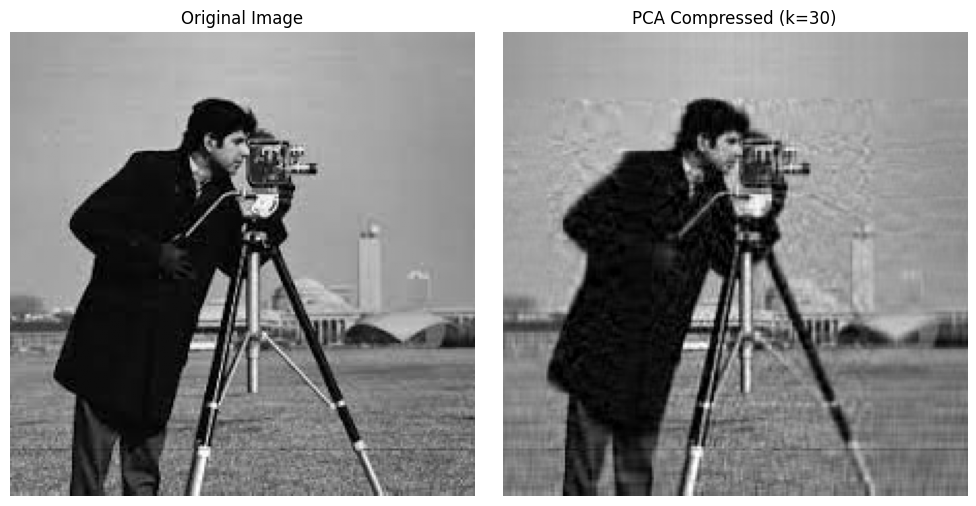

In [18]:

# ۱. بارگذاری تصویر
image_path = "cameraman.jpg"  # جایگزین کنید با مسیر تصویرتان
original_image = load_image(image_path)

# ۲. فشرده‌سازی
n_components = 30  # تعداد مؤلفه‌های اصلی — عدد کوچکتر ⇒ فشرده‌تر ولی کیفیت کمتر
compressed_image = compress_image(original_image, n_components)

# ۳. نمایش تصاویر
show_images(original_image, compressed_image, f'PCA Compressed (k={n_components})')

In [19]:
def save_image(image, path):
    img = (image * 255).astype(np.uint8)
    Image.fromarray(img).save(path)

save_image(compressed_image, "compressed_image.jpg")